## TUIA - Aprendizaje Automático 1

### Trabajo Práctico: Predicción de lluvia en Australia.

### Integrantes:
- Ponce, Daniel
- Yañez, Mirian

El presente informe detalla el trabajo práctico llevado a cabo para la predicción de las condiciones climáticas en Australia, centrándonos en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport. 

El conjunto de datos utilizado se denomina weatherAUS.csv y contiene información climática de los últimos diez años.

## Variables de Interés:

**RainTomorrow y RainfallTomorrow**: Estas variables representan nuestro objetivo de predicción, indicando si lloverá al día siguiente y la cantidad de lluvia, respectivamente.

"RainTomorrow" (categórica, para un problema de clasificación)

"RainfallTomorrow" (continua, para un problema de regresión).

## Paquetes y Librerias

In [24]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("code")
current_dir = os.path.dirname(os.path.realpath('__file__'))
data_source = os.path.join(current_dir, 'data', 'weatherAUS.csv')

from cleaning.clean import Clean
from regresion_lineal.regresion import RegressionLineal
from shap_analyzer.shap_analyzer import SHAPAnalyzer
from modelo_base.regression import RegresionModelBase
from modelo_base.clasification import ClasificacionModelBase
from neural_network.classification_neural import ClassificationNeuralNetwork
from neural_network.regression_neural import RegressionNeuralNetwork
from sklearn.model_selection import train_test_split


### **Importar el dataset**
### **Convertimos en variables numéricas las columnas 'RainToday' y 'RainTomorrow'**

In [25]:
df = pd.read_csv(data_source)
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# 2) Análisis descriptivo

Se realizará un análisis exploratorio del conjunto de datos para entender sus características principales y determinar si se requiere alguna acción para abordar datos faltantes, valores atípicos, la codificación de variables categóricas u otros procesos antes de proceder.

In [26]:
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [27]:
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,0.2


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        145412 non-null  int64  
 1   Date              145412 non-null  object 
 2   Location          145412 non-null  object 
 3   MinTemp           143928 non-null  float64
 4   MaxTemp           144159 non-null  float64
 5   Rainfall          142152 non-null  float64
 6   Evaporation       82658 non-null   float64
 7   Sunshine          75616 non-null   float64
 8   WindGustDir       135096 non-null  object 
 9   WindGustSpeed     135159 non-null  float64
 10  WindDir9am        134850 non-null  object 
 11  WindDir3pm        141186 non-null  object 
 12  WindSpeed9am      143645 non-null  float64
 13  WindSpeed3pm      142351 non-null  float64
 14  Humidity9am       142759 non-null  float64
 15  Humidity3pm       140907 non-null  float64
 16  Pressure9am       13

### **Hay un total de 145412 datos, 25 columnas y se puede observar que hay datos nulos en la mayoria de las variables.**

## Filtramos por las ciudades de interés

In [29]:
ciudades = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df[df['Location'].isin(ciudades)]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 30167 to 70370
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        15986 non-null  int64  
 1   Date              15986 non-null  object 
 2   Location          15986 non-null  object 
 3   MinTemp           15495 non-null  float64
 4   MaxTemp           15500 non-null  float64
 5   Rainfall          15199 non-null  float64
 6   Evaporation       14280 non-null  float64
 7   Sunshine          14038 non-null  float64
 8   WindGustDir       14529 non-null  object 
 9   WindGustSpeed     14531 non-null  float64
 10  WindDir9am        15291 non-null  object 
 11  WindDir3pm        15696 non-null  object 
 12  WindSpeed9am      15725 non-null  float64
 13  WindSpeed3pm      15737 non-null  float64
 14  Humidity9am       15416 non-null  float64
 15  Humidity3pm       15461 non-null  float64
 16  Pressure9am       15251 non-null  float64

### Ahora contamos con un total de 15986 datos.

### Cantidad de valores faltantes:

In [31]:
df.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp              491
MaxTemp              486
Rainfall             787
Evaporation         1706
Sunshine            1948
WindGustDir         1457
WindGustSpeed       1455
WindDir9am           695
WindDir3pm           290
WindSpeed9am         261
WindSpeed3pm         249
Humidity9am          570
Humidity3pm          525
Pressure9am          735
Pressure3pm          726
Cloud9am            2677
Cloud3pm            2932
Temp9am              505
Temp3pm              496
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
dtype: int64

### Estadística descriptiva de las variables numéricas
Examinamos medidas estadísticas, incluyendo valores mínimos, máximos, cuartiles, y medidas de centralidad como la mediana y la media.

In [32]:
df.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,15986.000000,15495.000000,15500.000000,15199.000000,14280.000000,14038.000000,14531.000000,15725.000000,15737.000000,15416.000000,15461.000000,15251.000000,15260.000000,13309.000000,13054.000000,15481.000000,15490.000000,15199.000000,15199.000000,15199.000000
mean,49512.619855,11.605221,21.751781,2.303744,4.866828,6.854694,44.417315,16.613672,21.797166,68.903023,51.280577,1018.305836,1016.064239,4.750545,4.746131,15.545953,20.229154,0.234094,0.233963,2.302586
std,15172.399796,5.851347,6.053679,7.385992,3.069869,3.842419,14.958027,10.336386,9.518033,15.614788,17.721335,7.400730,7.265386,2.728329,2.589879,5.559295,5.857956,0.423445,0.423363,7.385251
min,30176.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000,0.000000,0.000000
25%,34173.250000,7.900000,17.100000,0.000000,2.600000,3.700000,33.000000,9.000000,15.000000,59.000000,39.000000,1013.400000,1011.200000,2.000000,2.000000,11.600000,15.900000,0.000000,0.000000,0.000000
50%,47228.500000,11.600000,21.300000,0.000000,4.200000,7.500000,43.000000,15.000000,20.000000,70.000000,51.000000,1018.500000,1016.300000,6.000000,6.000000,15.400000,19.800000,0.000000,0.000000,0.000000
75%,66393.750000,15.800000,25.800000,0.800000,6.600000,10.000000,54.000000,22.000000,28.000000,80.000000,62.000000,1023.300000,1021.000000,7.000000,7.000000,19.500000,24.100000,0.000000,0.000000,0.800000
max,70391.000000,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,1.000000,1.000000,119.400000


Al analizar las columnas, se percibe que tanto la media como la mediana muestran una cercanía notable, lo que sugiere una tendencia consistente en los datos. Los desvíos en la dispersión de los datos no son extremos y la distribución no presentaria una gran extensión en un boxplot.

Los valores mínimos y máximos registrados estan considerablemente alejados de los valores centrales, lo cual señala la posible existencia de valores atípicos dentro del conjunto de datos.

### **Bloxplot**

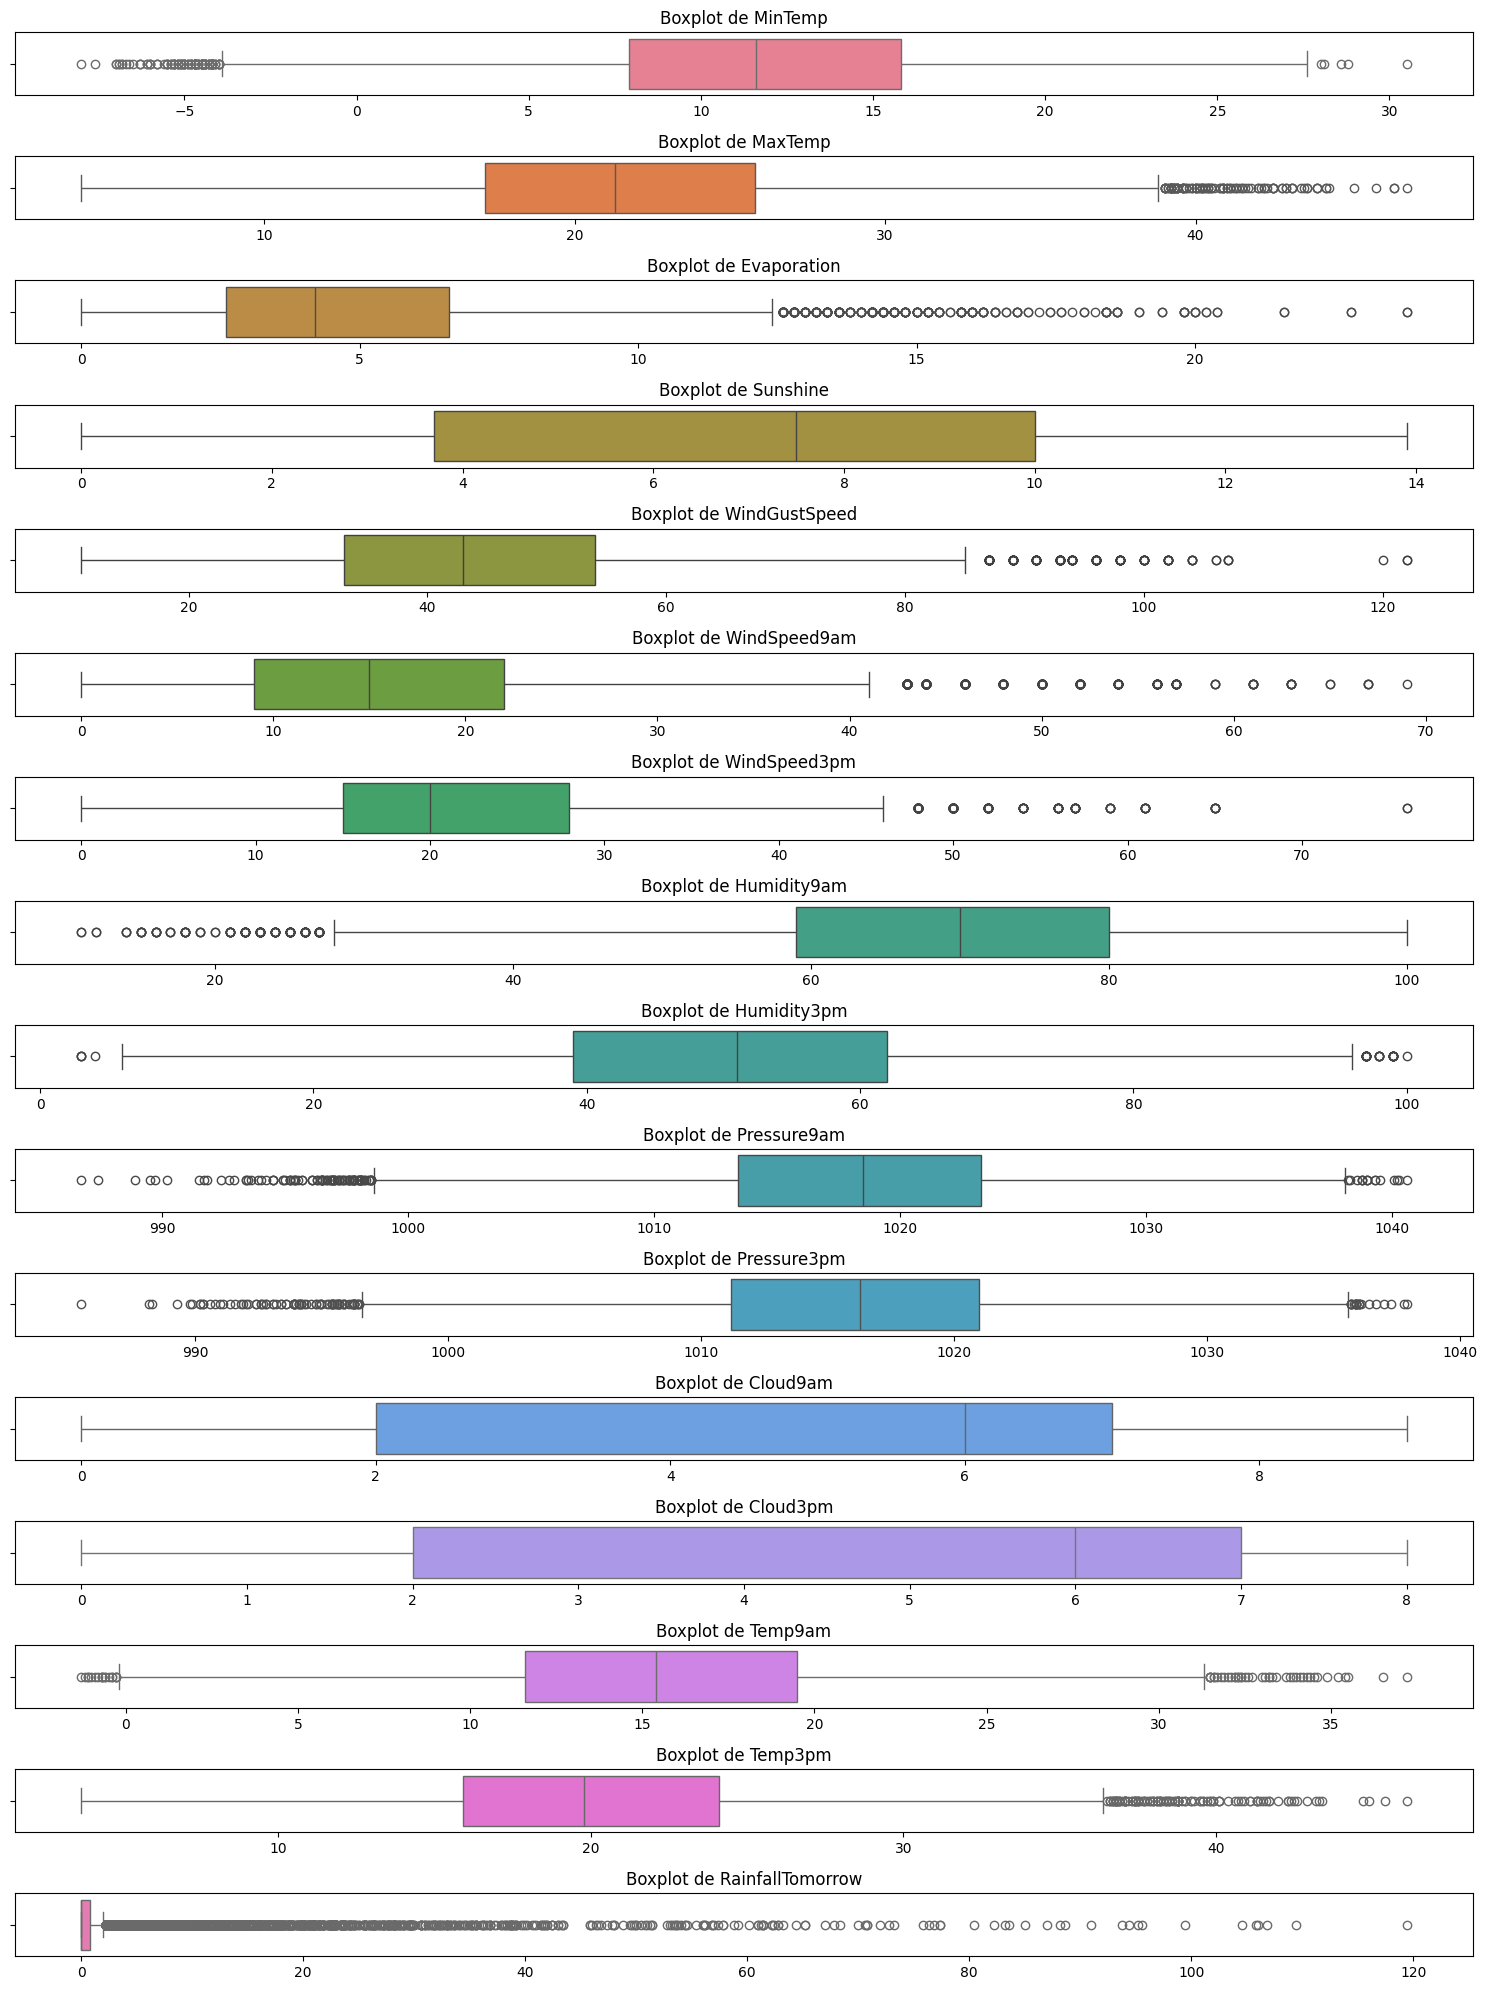

In [50]:
columnas_num = [
    'MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustSpeed',
    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
    'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainfallTomorrow'
]

colores = sns.color_palette('husl', n_colors=len(columnas_num))

fig, axes = plt.subplots(len(columnas_num), 1, figsize=(15, 20), sharex=False)

for i, col in enumerate(columnas_num):
    sns.boxplot(data=df, x=col, ax=axes[i], color=colores[i], orient='h')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('')

plt.tight_layout()

plt.show()

Al examinar los boxplots de las columnas numericas del dataset, se observa la presencia de valores atípicos en la mayoría de ellas. En algunas variables, estos valores están notablemente distanciados, mientras que en otras se distribuyen más cercanos y en ambos extremos del diagrama.

### Histogramas

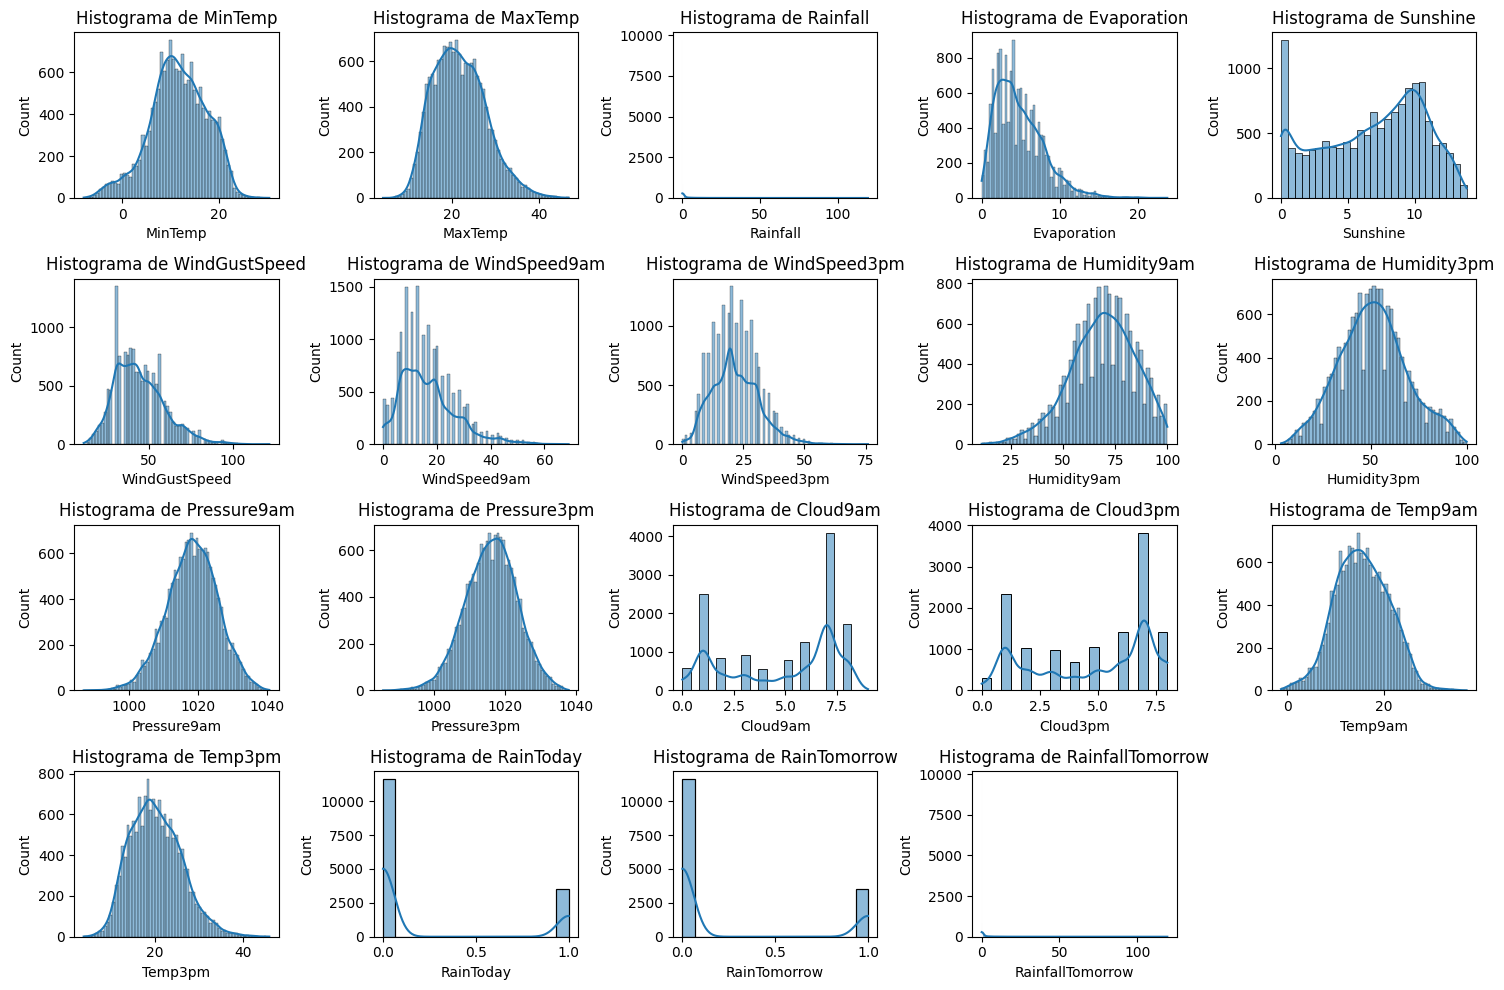

In [35]:
numeric_columns = df.select_dtypes(include=[np.float64]).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()


Para comprender más a fondo el comportamiento de los datos, empleamos histogramas donde se puede apreciar que algunas variables exhiben una distribución más uniforme de sus valores, como es el caso de la temperatura, humedad y presión. Por otro lado, existen variables que muestran la presencia de múltiples modas en los datos y una distribución menos uniforme.

Asimismo, se destaca que la variable Rainfall concentra la gran mayoría de sus datos en cero.

### Analizamos nuestra variable objetivo, la que queremos predecir para saber si el df esta balanceado o no.

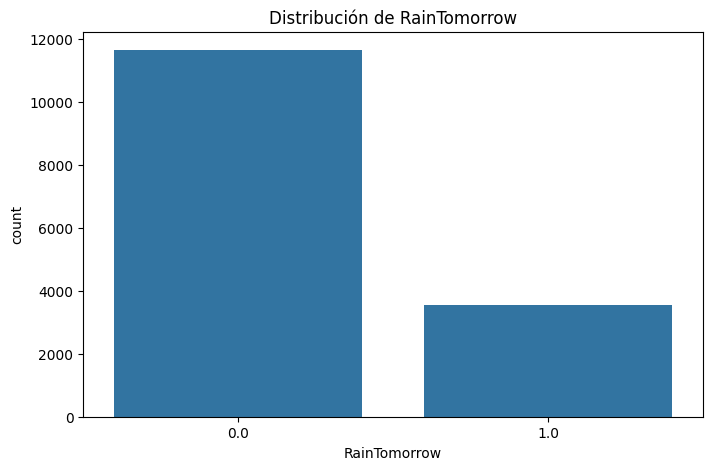

In [34]:
plt.figure(figsize=(8, 5))
sns.countplot(x='RainTomorrow', data=df)
plt.title('Distribución de RainTomorrow')
plt.show()

### Se observa que hay una mayor cantidad de datos donde no llueve (0) comparado con los días que llueve (1). Esto puede hacer que el modelo sea mejor para predecir dias en los que no llueva. Por esta razón, podemos decir que los datos no se encuentran balanceados

# Matriz de correlación 

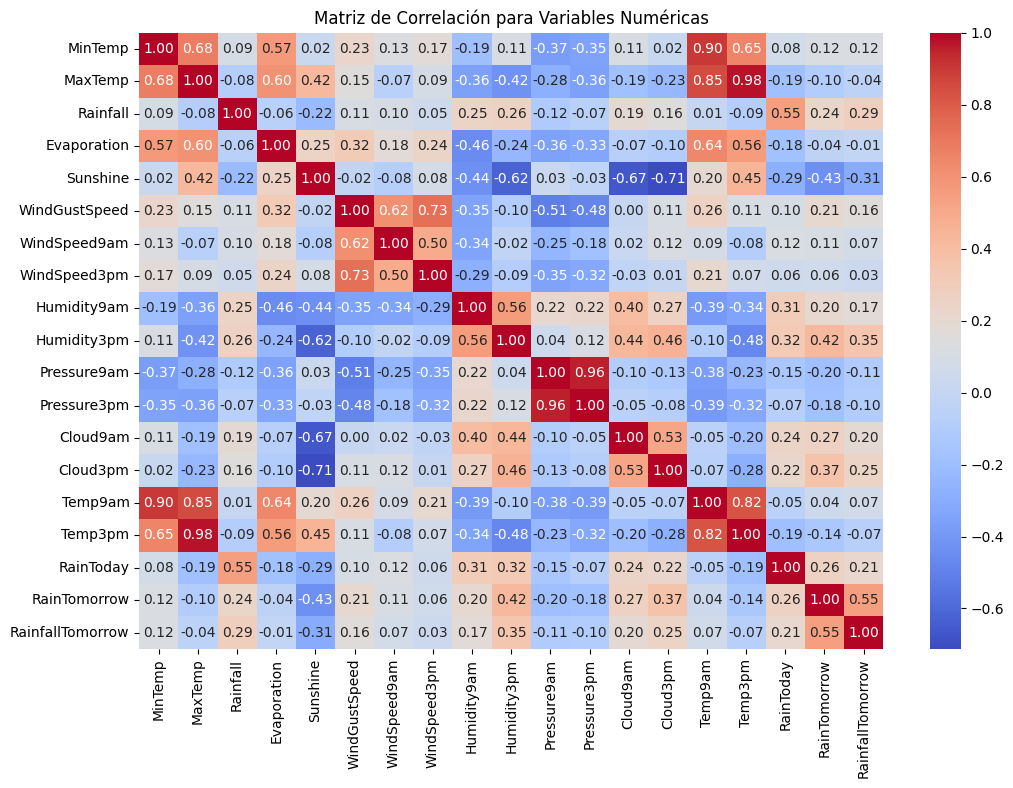

In [36]:
correlation_matrix_numeric = df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()


Podemos observar que las variables con mayor correlación con RainfallTomorrow son:

*   Humidity3pm (0.35)
*   Rainfall (0.29)
*   Cloud3pm (0.25)
*   Sunshine (-0.31)

y las variables con mayor correlación con RainTomorrow son:

*   Humidity3pm (0,42)
*   Cloud3pm (0.37)
*   Rainfall (0,24)
*   Sunshine (-0,43)

## Realizamos el split de entrenamiento y prueba

In [37]:
location_mapping = {'Canberra': 0, 'Melbourne': 1, 'MelbourneAirport': 2, 'Sydney': 3, 'SydneyAirport': 4}
df['Location___']=df['Location'].map(location_mapping)
df['Location']=df['Location___']
_x_train, _x_test, _y_train_regression, _y_test_regression, _y_train_classification, y_test_classification = split_dataset(df)

Luego de realizar el split, habíamos implementado la limpieza en la clase clean, pero al haber agregado la estandarización previamente los valores empeoraban mucho, por lo tanto optamos por dejar comentado el codigo de dicha limpieza y continuar con lo que nos daba mejores métricas

In [38]:
"""
data = Clean(_x_train)
data_clean = data.process()
data_clean.head()
"""

Archivo guardado exitosamente en 'data/weatherAUS_clean.csv'
<class 'pandas.core.frame.DataFrame'>
Index: 12788 entries, 35279 to 46492
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              12788 non-null  object 
 1   Location          12788 non-null  object 
 2   MinTemp           12788 non-null  float64
 3   MaxTemp           12788 non-null  float64
 4   Rainfall          12788 non-null  float64
 5   Evaporation       12788 non-null  float64
 6   Sunshine          12788 non-null  float64
 7   WindGustDir       12787 non-null  float64
 8   WindDir9am        12788 non-null  float64
 9   WindDir3pm        12788 non-null  float64
 10  WindSpeed9am      12788 non-null  float64
 11  WindSpeed3pm      12788 non-null  float64
 12  Humidity9am       12788 non-null  float64
 13  Humidity3pm       12788 non-null  float64
 14  Pressure9am       12788 non-null  float64
 15  Pressure3pm       12788 non

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
35279,2014-02-02,SydneyAirport,1.341772,0.988372,0.00,0.75,0.822581,67.5,67.5,45.0,...,-0.347826,-0.295918,-0.183673,-0.6,-1.0,1.250,1.085366,0.0,0.0,0.00
68559,2012-05-11,Melbourne,0.063291,-0.313953,1.25,-0.25,-0.258065,225.0,157.5,225.0,...,0.000000,-0.020408,0.102041,-0.2,0.0,-0.225,-0.414634,0.0,NaN,NaN
31088,2010-08-10,Sydney,-0.278481,-0.558140,3.50,-0.45,-1.225806,NaN,202.5,67.5,...,1.695652,0.071429,-0.255102,0.4,0.4,-0.400,-0.426829,1.0,1.0,5.75
68224,2011-06-11,Melbourne,-0.177215,-0.569767,0.00,-0.80,-0.048387,292.5,202.5,292.5,...,0.478261,1.173469,1.316327,-0.2,0.0,-0.525,-0.597561,0.0,NaN,NaN
31349,2011-05-28,Sydney,-0.379747,-0.441860,0.00,-0.25,-0.725806,292.5,180.0,270.0,...,0.695652,0.540816,0.632653,0.4,0.4,-0.625,-0.353659,0.0,0.0,0.00


In [39]:
#data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12788 entries, 35279 to 46492
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              12788 non-null  object 
 1   Location          12788 non-null  object 
 2   MinTemp           12788 non-null  float64
 3   MaxTemp           12788 non-null  float64
 4   Rainfall          12788 non-null  float64
 5   Evaporation       12788 non-null  float64
 6   Sunshine          12788 non-null  float64
 7   WindGustDir       12787 non-null  float64
 8   WindDir9am        12788 non-null  float64
 9   WindDir3pm        12788 non-null  float64
 10  WindSpeed9am      12788 non-null  float64
 11  WindSpeed3pm      12788 non-null  float64
 12  Humidity9am       12788 non-null  float64
 13  Humidity3pm       12788 non-null  float64
 14  Pressure9am       12788 non-null  float64
 15  Pressure3pm       12788 non-null  float64
 16  Cloud9am          12788 non-null  float64

In [40]:
#data_clean.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,12788.000000,12788.000000,12788.000000,12788.000000,12788.000000,12787.000000,12788.000000,12788.000000,12788.000000,12788.000000,...,12788.000000,12788.000000,12788.000000,12788.000000,12788.000000,12788.000000,12788.000000,12788.000000,12162.000000,12162.000000
mean,0.009652,0.055885,2.699249,0.154049,-0.103910,169.189020,171.403269,172.242532,0.111535,0.133827,...,0.006858,-0.015536,-0.018765,-0.248905,-0.250485,0.009269,0.056990,0.222318,0.230965,2.800732
std,0.732319,0.701842,8.959895,0.763875,0.611200,96.058931,83.856787,103.008048,0.792182,0.731351,...,0.766875,0.757736,0.741994,0.545312,0.518455,0.689791,0.711890,0.415820,0.421468,9.011943
min,-2.468354,-1.988372,0.000000,-1.050000,-1.225806,0.000000,0.000000,0.000000,-1.153846,-1.538462,...,-2.086957,-3.244898,-3.142857,-1.200000,-1.200000,-2.075000,-1.951220,0.000000,0.000000,0.000000
25%,-0.455696,-0.476744,0.000000,-0.450000,-0.596774,90.000000,90.000000,90.000000,-0.461538,-0.384615,...,-0.521739,-0.520408,-0.510204,-0.800000,-0.800000,-0.487500,-0.475610,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.016129,180.000000,180.000000,157.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012500,0.000000,0.000000,0.000000,0.000000
75%,0.531646,0.511628,0.750000,0.600000,0.387097,270.000000,247.500000,270.000000,0.538462,0.615385,...,0.478261,0.489796,0.479592,0.200000,0.200000,0.500000,0.524390,0.000000,0.000000,1.000000
max,2.189873,2.976744,149.250000,4.900000,1.016129,337.500000,337.500000,337.500000,4.153846,4.307692,...,2.130435,2.224490,2.193878,0.600000,0.400000,2.725000,3.219512,1.000000,1.000000,136.750000


In [41]:
#print(data_clean.columns)

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')


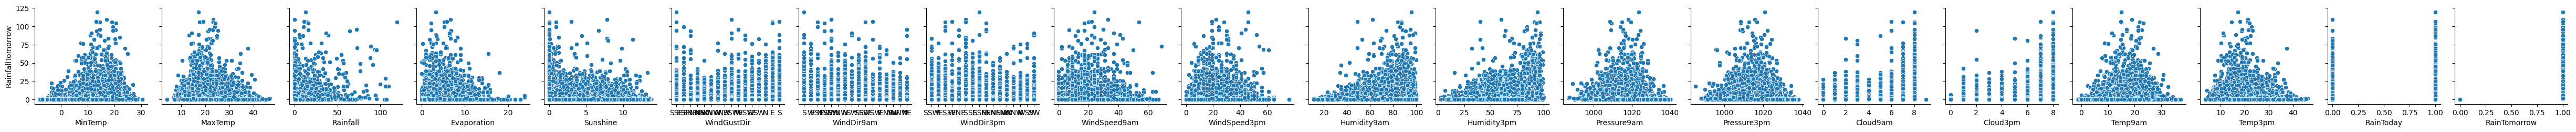

In [42]:
"""
columnas = [col for col in data_clean.columns if ((col != 'RainfallTomorrow') & (col != 'Location') & (col != 'Date'))]

sns.pairplot(df, x_vars=columnas, y_vars='RainfallTomorrow')
plt.show()
"""

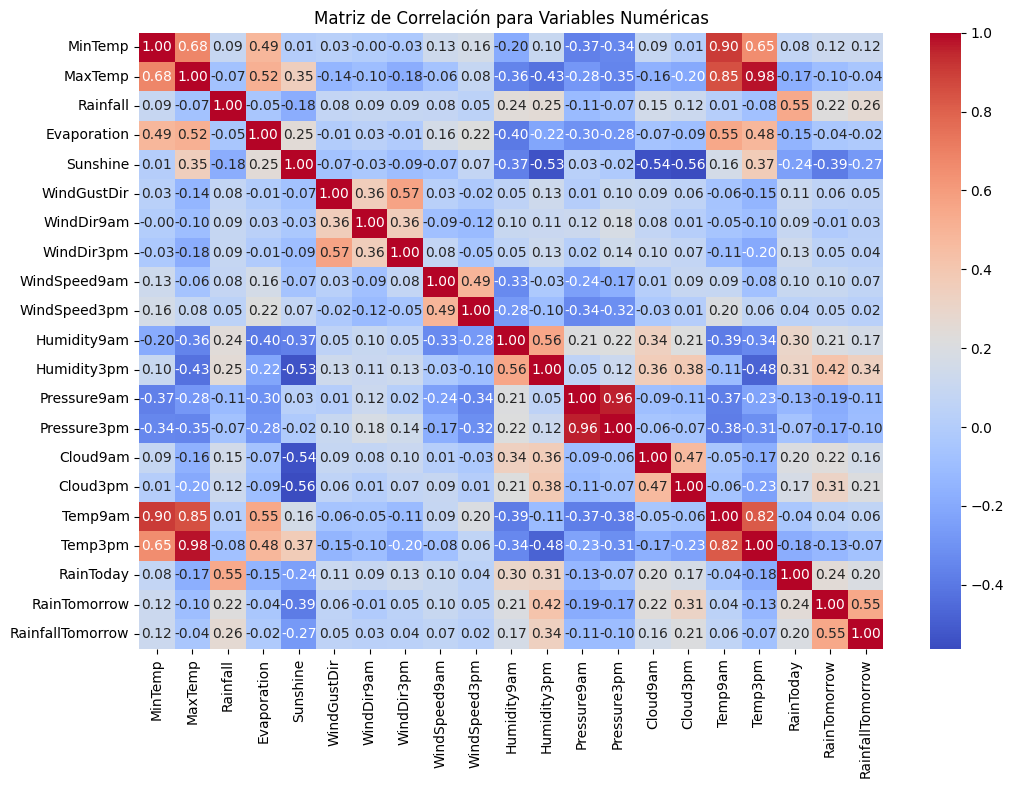

In [43]:
"""
numeric_columns = data_clean.select_dtypes(include=[np.float64, np.int32]).columns

correlation_matrix_numeric = data_clean[numeric_columns].corr()

# Plotear la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()
"""

### En esta parte implementamos en simultaneo las siguientes consignas:

* Implementar la solución del problema de regresión con regresión lineal múltiple.

* Optimizar la selección de hiperparámetros.

* Implementar explicabilidad del modelo. SHAP


In [44]:
regresion_clasic = RegressionLineal()
x_test, y_test_regression, y_pred, modelo = regresion_clasic.classic(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(f"Métricas del modelo Regresion lineal clasic:")
regresion_clasic.metrics(y_test_regression, y_pred)

TypeError: RegressionLineal.classic() missing 4 required positional arguments: 'x_train', 'x_test', 'y_train_regression', and 'y_test_regression'

In [ ]:
#aplicamos validación cruzada
regresion_clasic.cross_validate(_y_test_regression, _y_test_regression, modelo, cv=5)

       Rainfall  Humidity3pm  Cloud3pm
65197      0.00    -0.173913      -0.4
64828      0.00    -0.695652       0.2
46689      0.00    -1.391304      -1.0
33430      0.25    -0.391304      -0.6
67471      0.00     0.347826      -0.6
...         ...          ...       ...
67439      0.00    -1.347826      -1.0
45955      0.00    -1.260870      -1.0
68057      2.25     1.086957      -0.2
46004      0.00    -1.739130      -0.2
47556      0.00     0.478261       0.4

[2558 rows x 3 columns]
Mean Squared Error (CV): 69.91302674319513
R^2 Score (CV): 0.15195761204470315
Mean Absolute Error (CV): 3.927958098117468
El modelo
       Rainfall  Humidity3pm  Cloud3pm
65197      0.00    -0.173913      -0.4
64828      0.00    -0.695652       0.2
46689      0.00    -1.391304      -1.0
33430      0.25    -0.391304      -0.6
67471      0.00     0.347826      -0.6
...         ...          ...       ...
67439      0.00    -1.347826      -1.0
45955      0.00    -1.260870      -1.0
68057      2.25     1.0

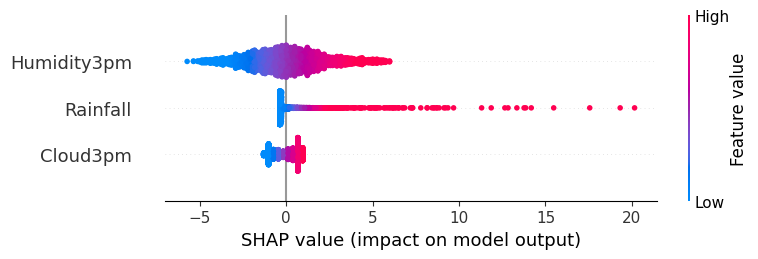

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
print('métodos de gradiente descendiente')
regresion_gradient_desecent = RegressionLineal()
x_test, y_test, y_pred, modelo = regresion_gradient_desecent.gradient_descent(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(f"Métricas del Modelo:")
regresion_gradient_desecent.metrics(y_test, y_pred)


métodos de gradiente descendiente
Métricas del Modelo:
{'MSE': 2.280639195731397e+25, 'R2': -2.966765995756873e+23, 'RMSE': 4775603831696.466, 'MAE': 1346064117461.2651, 'MAPE': inf}


In [ ]:
#aplicamos validación cruzada
regresion_gradient_desecent.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 9.808317489136102e+24
R^2 Score (CV): -1.2759134744689166e+23
Mean Absolute Error (CV): 477986273582.9664


(9.808317489136102e+24, -1.2759134744689166e+23, 477986273582.9664)

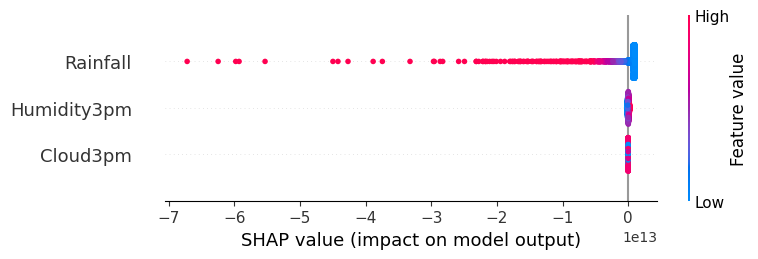

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}


regresion_gradient_descent = RegressionLineal()
x_test, y_test, y_pred, best_model = regresion_gradient_descent.gradient_descent_optimize_hyperparameters(param_grid, _x_train, _x_test, _y_train_regression, _y_test_regression)

regresion_gradient_descent.metrics(y_test, y_pred)

Métricas del mejor modelo:
{'MSE': 66.07186250620663, 'R2': 0.1405051911471945, 'RMSE': 8.128460032884865, 'MAE': 3.761437365286137, 'MAPE': inf}
Mejores hiperparámetros: {'alpha': 0.1, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'squared_error', 'max_iter': 500, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


## Regresión linean de Lasso

In [ ]:
# regresion de Lasso
regresion_lasso = RegressionLineal()
x_test, y_test, y_pred, lasso_model = regresion_lasso.lasso_regression(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(f"Métricas del modelo Regresion lineal Lasso:")
regresion_lasso.metrics(y_test, y_pred)

Métricas del modelo Regresion lineal Lasso:
{'MSE': 68.12861114333221, 'R2': 0.1137500080833228, 'RMSE': 8.254005763466138, 'MAE': 3.6174426512939863, 'MAPE': inf}


In [ ]:
#aplicamos validación cruzada
regresion_lasso.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 2.0802546016900694e+23
R^2 Score (CV): -2.706096004296561e+21
Mean Absolute Error (CV): 89446654331.96501


(2.0802546016900694e+23, -2.706096004296561e+21, 89446654331.96501)

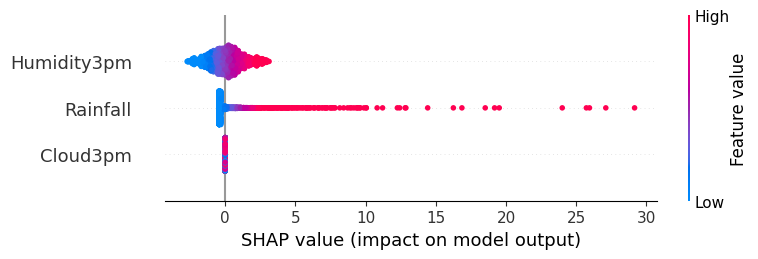

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(lasso_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Lasso', param_grid_lasso)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Lasso:")
print(metricas_lasso)
print("Mejores hiperparámetros para Lasso:", best_lasso_model.get_params())


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Métricas del mejor modelo Lasso:
{'MSE': 66.0838603270938, 'R2': 0.14034911767841485, 'RMSE': 8.129198012540586, 'MAE': 3.8215767460872487, 'MAPE': inf}
Mejores hiperparámetros para Lasso: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Regresión lineal de Ridge

In [ ]:
# regresion de Ridge

regresion_ridge = RegressionLineal(data_clean)
x_test, y_test, y_pred, ridge_model = regresion_ridge.ridge_regression()
metricas = regresion_lasso.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Ridge:")
print(metricas)


Métricas del modelo Regresion lineal Ridge:
{'MSE': 66.08700065508452, 'R2': 0.14030826676996855, 'RMSE': 8.12939116140222, 'MAE': 3.826983032173833, 'MAPE': inf}


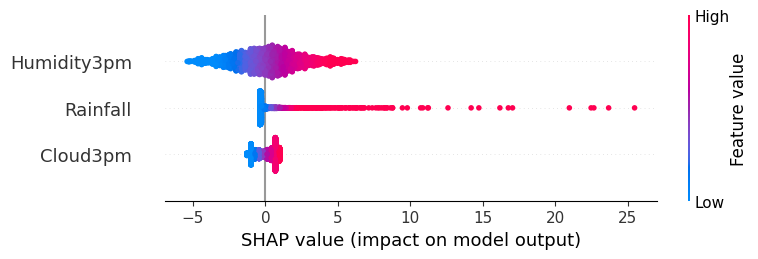

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(ridge_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Ridge = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Ridge', param_grid_Ridge)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Ridge:")
print(metricas_lasso)
print("Mejores hiperparámetros para Ridge:", best_lasso_model.get_params())

Métricas del mejor modelo Ridge:
{'MSE': 66.08445144448267, 'R2': 0.14034142813693873, 'RMSE': 8.129234370128756, 'MAE': 3.81311955943779, 'MAPE': inf}
Mejores hiperparámetros para Ridge: {'alpha': 100.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


## Regresión lineal de Elasticnet

In [ ]:
# regresion de Elasticnet

regresion_elasticnet = RegressionLineal(data_clean)
x_test, y_test, y_pred, elasticnet_model = regresion_elasticnet.elasticnet_regression()

metricas = regresion_elasticnet.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Elasticnet:")
print(metricas)

Métricas del modelo Regresion lineal Elasticnet:
{'MSE': 68.4876878653982, 'R2': 0.10907896405809026, 'RMSE': 8.275728841944872, 'MAE': 3.6211542264848484, 'MAPE': inf}


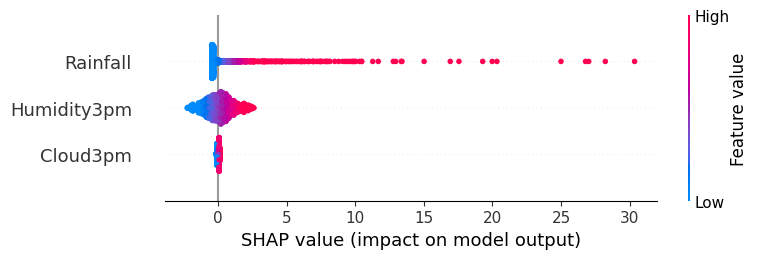

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(elasticnet_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Puedes ajustar estos valores según sea necesario
}
# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_elasticnet, best_lasso_model = regresion_lineal.optimize_hyperparameters('ElasticNet', param_grid_Elasticnet)

# Calcular métricas
metricas_elasticnet = regresion_lineal.metrics(y_test, y_pred_elasticnet)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Elasticnet:")
print(metricas_elasticnet)
print("Mejores hiperparámetros para Elasticnet:", best_lasso_model.get_params())

Métricas del mejor modelo Elasticnet:
{'MSE': 66.08390150786934, 'R2': 0.14034858197892863, 'RMSE': 8.129200545433072, 'MAE': 3.8189027000206934, 'MAPE': inf}
Mejores hiperparámetros para Elasticnet: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.7, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Regresión Logística

In [ ]:
#regresion logistica
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic()
regression_logistic.logic_metrics(y_test, y_pred)

2024-02-25 18:58:24,692 - regression - ERROR - Error en el entrenamiento de regresión logística: Found input variables with inconsistent numbers of samples: [1, 12788]
2024-02-25 18:58:24,692 - regression - ERROR - Error en el entrenamiento de regresión logística: Found input variables with inconsistent numbers of samples: [1, 12788]
2024-02-25 18:58:24,692 - regression - ERROR - Error en el entrenamiento de regresión logística: Found input variables with inconsistent numbers of samples: [1, 12788]
2024-02-25 18:58:24,692 - regression - ERROR - Error en el entrenamiento de regresión logística: Found input variables with inconsistent numbers of samples: [1, 12788]
2024-02-25 18:58:24,692 - regression - ERROR - Error en el entrenamiento de regresión logística: Found input variables with inconsistent numbers of samples: [1, 12788]
2024-02-25 18:58:24,692 - regression - ERROR - Error en el entrenamiento de regresión logística: Found input variables with inconsistent numbers of samples: [1,

ValueError: Error en el entrenamiento de regresión logística: Found input variables with inconsistent numbers of samples: [1, 12788]

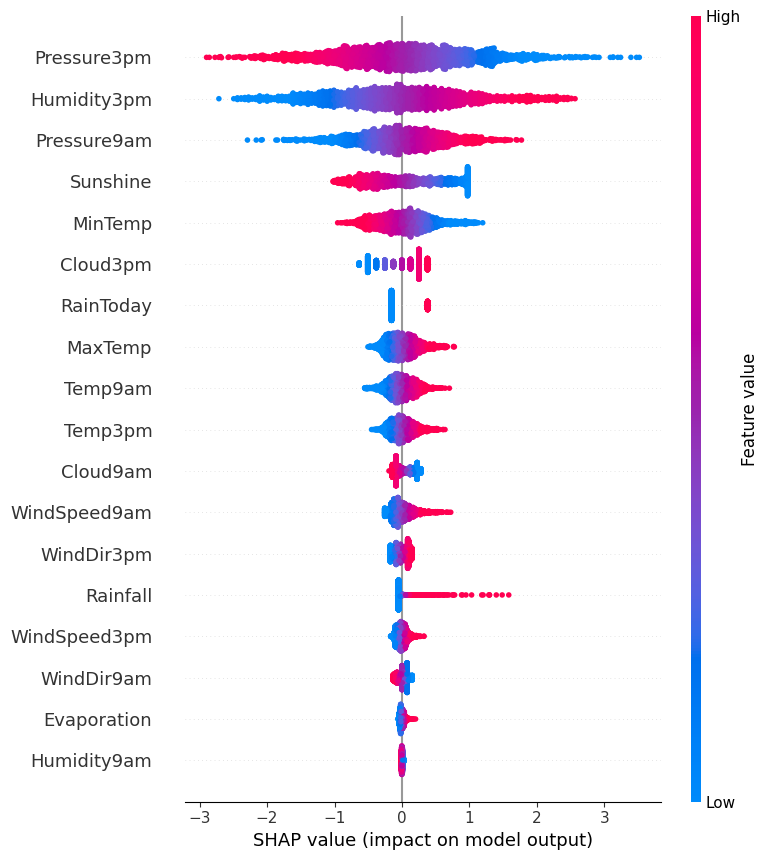

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
regresion_lineal = RegressionLineal(data_clean)
#buscando los hipperparametros
param_grid_logistic = {
    'C': [ 0.01, 0.1],
    'penalty': ['l1'],
    'solver': ['liblinear']
}
x_test_logistic, y_test_logistic, y_pred_logistic, best_logistic_model = regresion_lineal.optimize_hyperparameters_logistic(param_grid_logistic)

# Calcular métricas
metricas_logistic = regresion_lineal.metrics(y_test_logistic, y_pred_logistic)

# Imprimir métricas y mejores hiperparámetros para la regresión logística
print(f"Métricas del mejor modelo de regresión logística:")
print(metricas_logistic)
print("Mejores hiperparámetros para la regresión logística:", best_logistic_model.get_params())


The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.


Métricas del mejor modelo de regresión logística:
{'MSE': 0.17357310398749023, 'R2': 0.00145330818837619, 'RMSE': 0.41662105562188073, 'MAE': 0.17357310398749023, 'MAPE': inf}
Mejores hiperparámetros para la regresión logística: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Observamos que tanto el modelo como la validación cruzada tienden a sobreajustar las predicciones hacia la clase negativa. Esto se debe a que la clase negativa es la más predominante. Para abordar este desbalance, procedemos a equilibrar las clases.

Accuracy: 0.76
Precision: 0.48
Recall: 0.71
F1 Score: 0.57
ROC-AUC: 0.74
Matiz de confusión:
          pred: No  Pred: Si
Real: No      1536       449
Real: si       165       408


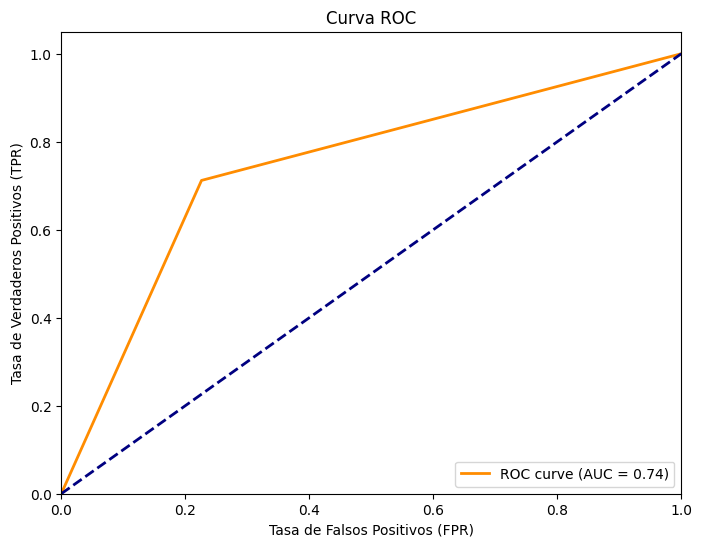

In [ ]:
#regresion logistica balanceada
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic_balanced()
regression_logistic.logic_metrics(y_test, y_pred)

### Optamos por mantener el modelo balanceado, ya que aunque observamos una disminución en las métricas de predicción negativa, consideramos prioritario mejorar las métricas de predicción positiva. En este contexto, valoramos una mayor precisión en la anticipación de días lluviosos.

## Implementar un modelo base para clasificación y uno para regresión

In [ ]:
clasificacion_modelo_base = ClasificacionModelBase(data_clean)
metricas_rendimiento_base = clasificacion_modelo_base.train_and_evaluate()

print("Métricas de rendimiento del modelo base de clasificación:")
for metric, value in metricas_rendimiento_base.items():
    print(f"{metric}: {value:.2f}")

Métricas de rendimiento del modelo base de clasificación:
Accuracy: 0.78
Precision: 0.78
Recall: 1.00
F1-score: 0.87


In [ ]:
modelo_regresion_base = RegresionModelBase(data_clean)
modelo_entrenado, error_cuadratico_medio, coeficiente_determinacion = modelo_regresion_base.train()

print("Métricas de rendimiento:")
print(f"Error cuadrático medio (MSE): {error_cuadratico_medio:.2f}")
print(f"Coeficiente de determinación (R^2): {coeficiente_determinacion:.2f}")


Métricas de rendimiento:
Error cuadrático medio (MSE): 74.14
Coeficiente de determinación (R^2): 0.04


## Implementar las soluciones con una red neuronal

In [ ]:
print('=============================clasificacion con redes neuronales================================================')
classification_nn_model = ClassificationNeuralNetwork(data_clean)
trained_model = classification_nn_model.classification()


[I 2024-02-25 18:43:34,872] A new study created in memory with name: no-name-3ffabfbd-994e-42e9-8584-ba29b69e6695


=============================clasificacion con redes neuronales================================================



80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:43:42,570] Trial 0 finished with value: 0.21696637998436274 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 7.167714064118088e-05}. Best is trial 0 with value: 0.21696637998436274.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:43:51,710] Trial 1 finished with value: 0.22400312744331508 and parameters: {'num_layers': 3, 'n_units_l0': 4, 'n_units_l1': 6, 'n_units_l2': 6, 'learning_rate': 0.020846279408994178}. Best is trial 0 with value: 0.21696637998436274.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:44:01,714] Trial 2 finished with value: 0.22087568412822522 and parameters: {'num_layers': 3, 'n_units_l0': 6, 'n_units_l1': 3, 'n_units_l2': 9, 'learning_rate': 0.0015495111423185065}. Best is trial 0 with value: 0.21696637998436274.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:44:08,319] Trial 3 finished with value: 0.21110242376856925 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.002898873512339462}. Best is trial 3 with value: 0.21110242376856925.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:44:17,927] Trial 4 finished with value: 0.22400312744331508 and parameters: {'num_layers': 3, 'n_units_l0': 7, 'n_units_l1': 8, 'n_units_l2': 5, 'learning_rate': 0.03105792771047214}. Best is trial 3 with value: 0.21110242376856925.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:44:26,756] Trial 5 finished with value: 0.2799061767005473 and parameters: {'num_layers': 2, 'n_units_l0': 5, 'n_units_l1': 14, 'learning_rate': 3.744301180947113e-05}. Best is trial 3 with value: 0.21110242376856925.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:44:37,417] Trial 6 finished with value: 0.22400312744331508 and parameters: {'num_layers': 3, 'n_units_l0': 2, 'n_units_l1': 14, 'n_units_l2': 7, 'learning_rate': 6.166781145646766e-05}. Best is trial 3 with value: 0.21110242376856925.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:44:45,131] Trial 7 finished with value: 0.22283033620015635 and parameters: {'num_layers': 1, 'n_units_l0': 7, 'learning_rate': 0.009920251085918609}. Best is trial 3 with value: 0.21110242376856925.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:44:53,657] Trial 8 finished with value: 0.19937451133698203 and parameters: {'num_layers': 2, 'n_units_l0': 11, 'n_units_l1': 11, 'learning_rate': 0.0016432524186469934}. Best is trial 8 with value: 0.19937451133698203.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:45:04,439] Trial 9 finished with value: 0.22243940578577015 and parameters: {'num_layers': 3, 'n_units_l0': 10, 'n_units_l1': 9, 'n_units_l2': 14, 'learning_rate': 0.006909361494518807}. Best is trial 8 with value: 0.19937451133698203.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:45:13,095] Trial 10 finished with value: 0.21579358874120402 and parameters: {'num_layers': 2, 'n_units_l0': 14, 'n_units_l1': 11, 'learning_rate': 0.00043239618180713465}. Best is trial 8 with value: 0.19937451133698203.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:45:20,169] Trial 11 finished with value: 0.1978107896794371 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 0.0017490560790250013}. Best is trial 11 with value: 0.1978107896794371.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:45:28,804] Trial 12 finished with value: 0.22400312744331508 and parameters: {'num_layers': 2, 'n_units_l0': 12, 'n_units_l1': 16, 'learning_rate': 0.08659229120858404}. Best is trial 11 with value: 0.1978107896794371.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:45:35,882] Trial 13 finished with value: 0.17787333854573883 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 0.0005051728837013988}. Best is trial 13 with value: 0.17787333854573883.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:45:43,410] Trial 14 finished with value: 0.1759186864738077 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.000414960249725627}. Best is trial 14 with value: 0.1759186864738077.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:45:50,979] Trial 15 finished with value: 0.17161845191555902 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0003194510342826412}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:45:58,199] Trial 16 finished with value: 0.18060985144644248 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.00015457672767016907}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:46:05,120] Trial 17 finished with value: 0.3174354964816263 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 1.0592566748425513e-05}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:46:13,626] Trial 18 finished with value: 0.22400312744331508 and parameters: {'num_layers': 2, 'n_units_l0': 16, 'n_units_l1': 1, 'learning_rate': 0.0002631872600324277}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:46:20,719] Trial 19 finished with value: 0.1759186864738077 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0007738120173139794}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:46:29,592] Trial 20 finished with value: 0.22361219702892887 and parameters: {'num_layers': 2, 'n_units_l0': 13, 'n_units_l1': 5, 'learning_rate': 0.00022946548150992976}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:46:36,897] Trial 21 finished with value: 0.18060985144644248 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.000804594433148944}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:46:43,986] Trial 22 finished with value: 0.17865519937451135 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0007465251032090729}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:46:51,114] Trial 23 finished with value: 0.17748240813135263 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0003934373446159487}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:46:58,127] Trial 24 finished with value: 0.17982799061767007 and parameters: {'num_layers': 1, 'n_units_l0': 9, 'learning_rate': 0.0009370523258629164}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:47:05,198] Trial 25 finished with value: 0.18412822517591865 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.00014268760421380698}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:47:12,223] Trial 26 finished with value: 0.1868647380766224 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.0027658523036462705}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:47:20,498] Trial 27 finished with value: 0.22400312744331508 and parameters: {'num_layers': 2, 'n_units_l0': 15, 'n_units_l1': 1, 'learning_rate': 0.0005373624276733226}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:47:27,690] Trial 28 finished with value: 0.181391712275215 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 0.0002720915725741408}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:47:34,895] Trial 29 finished with value: 0.17748240813135263 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0001117705494978306}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:47:42,155] Trial 30 finished with value: 0.22283033620015635 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 7.84769123173384e-05}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:47:49,977] Trial 31 finished with value: 0.17200938232994523 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0003610615550499591}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:47:57,304] Trial 32 finished with value: 0.1755277560594214 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0002807415013017069}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:48:05,571] Trial 33 finished with value: 0.17474589523064898 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0003060998272322569}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:48:13,979] Trial 34 finished with value: 0.1982017200938233 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.00023201571621472218}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:48:21,438] Trial 35 finished with value: 0.18060985144644248 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0013315548338597057}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:48:29,106] Trial 36 finished with value: 0.18021892103205628 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.00016397805234229901}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:48:38,259] Trial 37 finished with value: 0.25605942142298665 and parameters: {'num_layers': 2, 'n_units_l0': 12, 'n_units_l1': 5, 'learning_rate': 8.475784636836579e-05}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:48:45,349] Trial 38 finished with value: 0.4765441751368257 and parameters: {'num_layers': 1, 'n_units_l0': 3, 'learning_rate': 4.1422802123101905e-05}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:48:52,479] Trial 39 finished with value: 0.1759186864738077 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0003119018173142484}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:49:03,436] Trial 40 finished with value: 0.22126661454261143 and parameters: {'num_layers': 3, 'n_units_l0': 8, 'n_units_l1': 16, 'n_units_l2': 16, 'learning_rate': 0.0001831560878490689}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:49:11,125] Trial 41 finished with value: 0.17904612978889756 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.0003539321696961528}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:49:18,247] Trial 42 finished with value: 0.17748240813135263 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0005978543697944935}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:49:25,451] Trial 43 finished with value: 0.17435496481626267 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.00042539652610569474}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:49:32,976] Trial 44 finished with value: 0.1767005473025801 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0013438443472047375}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:49:41,969] Trial 45 finished with value: 0.22400312744331508 and parameters: {'num_layers': 2, 'n_units_l0': 1, 'n_units_l1': 11, 'learning_rate': 0.00011426582756570001}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:49:49,258] Trial 46 finished with value: 0.18569194683346368 and parameters: {'num_layers': 1, 'n_units_l0': 5, 'learning_rate': 0.0005816018255914194}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:49:56,680] Trial 47 finished with value: 0.1759186864738077 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.00033656363726110305}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:50:05,950] Trial 48 finished with value: 0.21266614542611417 and parameters: {'num_layers': 2, 'n_units_l0': 14, 'n_units_l1': 7, 'learning_rate': 0.00022239899852263687}. Best is trial 15 with value: 0.17161845191555902.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:50:14,246] Trial 49 finished with value: 0.18412822517591865 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0011336769656536915}. Best is trial 15 with value: 0.17161845191555902.


Mejor valor encontrado: 0.17161845191555902
Mejores hiperparámetros: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0003194510342826412}
80/80 [==============================] - 0s 1ms/step
Precisión en el conjunto de prueba: 0.7906976744186046
Recall en el conjunto de prueba: 0.29668411867364747
F1-score en el conjunto de prueba: 0.43147208121827413
Exactitud en el conjunto de prueba: 0.8248631743549648


In [ ]:
regression_nn_model = RegressionNeuralNetwork(data_clean)
regression_nn_model.regression()

[I 2024-02-25 18:50:21,237] A new study created in memory with name: no-name-a1ab56f7-90bf-4f4f-995e-104c1ab4d195
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:50:27,135] Trial 0 finished with value: 68.6611821550877 and parameters: {'learning_rate': 0.0637490667528701}. Best is trial 0 with value: 68.6611821550877.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:50:33,296] Trial 1 finished with value: 82.56810756482834 and parameters: {'learning_rate': 0.00012827945491358835}. Best is trial 0 with value: 68.6611821550877.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:50:39,388] Trial 2 finished with value: 68.87017056282666 and parameters: {'learning_rate': 0.005139474333137335}. Best is trial 0 with value: 68.6611821550877.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:50:45,106] Trial 3 finished with value: 68.44224865902834 and parameters: {'learning_rate': 0.02547857002536178}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:50:51,014] Trial 4 finished with value: 69.01353316981104 and parameters: {'learning_rate': 0.001868383372142379}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:50:57,126] Trial 5 finished with value: 68.61343811779918 and parameters: {'learning_rate': 0.026965785694951016}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:03,570] Trial 6 finished with value: 68.54671634105114 and parameters: {'learning_rate': 0.017577670895184024}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:09,979] Trial 7 finished with value: 71.29755844092672 and parameters: {'learning_rate': 0.0007011053749753172}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:16,300] Trial 8 finished with value: 69.96150215285911 and parameters: {'learning_rate': 0.0012036654707588488}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:22,758] Trial 9 finished with value: 84.19082011344496 and parameters: {'learning_rate': 1.140709325379349e-05}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:28,127] Trial 10 finished with value: 68.59928692740267 and parameters: {'learning_rate': 0.05567770287474034}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:33,381] Trial 11 finished with value: 68.58110739665156 and parameters: {'learning_rate': 0.01795072087792901}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:38,651] Trial 12 finished with value: 68.59828523432313 and parameters: {'learning_rate': 0.008460701951937629}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:43,908] Trial 13 finished with value: 69.09041396653502 and parameters: {'learning_rate': 0.085114063200916}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 987us/step


[I 2024-02-25 18:51:49,185] Trial 14 finished with value: 68.53042981257387 and parameters: {'learning_rate': 0.01867373587609031}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:54,183] Trial 15 finished with value: 68.77610133682761 and parameters: {'learning_rate': 0.005396084222295996}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:51:59,381] Trial 16 finished with value: 69.06247593379378 and parameters: {'learning_rate': 0.09402991472111534}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:04,605] Trial 17 finished with value: 68.49420732031571 and parameters: {'learning_rate': 0.028088848528665576}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:09,541] Trial 18 finished with value: 68.5137996075286 and parameters: {'learning_rate': 0.03006645622524555}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:14,939] Trial 19 finished with value: 68.72459250038382 and parameters: {'learning_rate': 0.00800420096106988}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:20,311] Trial 20 finished with value: 68.91508251007326 and parameters: {'learning_rate': 0.0030968979089306}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:25,668] Trial 21 finished with value: 68.59205202198623 and parameters: {'learning_rate': 0.032778247092191966}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:31,306] Trial 22 finished with value: 68.9856355454543 and parameters: {'learning_rate': 0.04188489732093168}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:36,604] Trial 23 finished with value: 68.57845122373794 and parameters: {'learning_rate': 0.015659885756237467}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:42,058] Trial 24 finished with value: 69.02009186979703 and parameters: {'learning_rate': 0.03852772841075163}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 2ms/step


[I 2024-02-25 18:52:48,334] Trial 25 finished with value: 69.79846739573283 and parameters: {'learning_rate': 0.09820106415451028}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:53,965] Trial 26 finished with value: 68.6963737349343 and parameters: {'learning_rate': 0.010478343961052544}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:52:59,298] Trial 27 finished with value: 68.57297171171763 and parameters: {'learning_rate': 0.02424919358723712}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:53:05,470] Trial 28 finished with value: 68.60358137915297 and parameters: {'learning_rate': 0.04606976460623095}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:53:11,761] Trial 29 finished with value: 68.87734742813029 and parameters: {'learning_rate': 0.05676560418367379}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:53:17,498] Trial 30 finished with value: 68.63669682290906 and parameters: {'learning_rate': 0.011734139958315265}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:53:23,076] Trial 31 finished with value: 68.53845613127437 and parameters: {'learning_rate': 0.024625990749501128}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:53:29,027] Trial 32 finished with value: 68.60498044559995 and parameters: {'learning_rate': 0.01611406417592756}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:53:35,177] Trial 33 finished with value: 68.6932764271525 and parameters: {'learning_rate': 0.004710943039707671}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:53:41,438] Trial 34 finished with value: 68.5190664760316 and parameters: {'learning_rate': 0.048789709352815146}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:53:47,549] Trial 35 finished with value: 68.64706187953175 and parameters: {'learning_rate': 0.05928445725495976}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:53:53,847] Trial 36 finished with value: 68.538643333016 and parameters: {'learning_rate': 0.03495596092658664}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:00,204] Trial 37 finished with value: 68.55612261332718 and parameters: {'learning_rate': 0.025599332802948575}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:06,417] Trial 38 finished with value: 68.54190887177934 and parameters: {'learning_rate': 0.06521422809353826}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:12,517] Trial 39 finished with value: 68.59078129045571 and parameters: {'learning_rate': 0.01205014226611808}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:18,642] Trial 40 finished with value: 68.83208338339666 and parameters: {'learning_rate': 0.0024153917064411185}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:25,437] Trial 41 finished with value: 68.6343520248784 and parameters: {'learning_rate': 0.02067051160567354}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:31,608] Trial 42 finished with value: 68.52982042733352 and parameters: {'learning_rate': 0.03153562898896623}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:37,790] Trial 43 finished with value: 68.64041068230983 and parameters: {'learning_rate': 0.03408990933910348}. Best is trial 3 with value: 68.44224865902834.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:44,315] Trial 44 finished with value: 68.4409092776891 and parameters: {'learning_rate': 0.07578671375443971}. Best is trial 44 with value: 68.4409092776891.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:50,419] Trial 45 finished with value: 68.50875489544143 and parameters: {'learning_rate': 0.0567075558202098}. Best is trial 44 with value: 68.4409092776891.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:54:56,408] Trial 46 finished with value: 68.82008323148862 and parameters: {'learning_rate': 0.08200299768224921}. Best is trial 44 with value: 68.4409092776891.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:55:02,427] Trial 47 finished with value: 68.90512508175534 and parameters: {'learning_rate': 0.06432259572504796}. Best is trial 44 with value: 68.4409092776891.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:55:08,504] Trial 48 finished with value: 69.90078589231322 and parameters: {'learning_rate': 0.09639474756953598}. Best is trial 44 with value: 68.4409092776891.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


80/80 [==============================] - 0s 1ms/step


[I 2024-02-25 18:55:14,597] Trial 49 finished with value: 68.70178569210893 and parameters: {'learning_rate': 0.014548248173771903}. Best is trial 44 with value: 68.4409092776891.


Epoch 1/10
320/320 [==============================] - 1s 2ms/step - loss: 69.8197
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 69.0270
Epoch 3/10
320/320 [==============================] - 0s 2ms/step - loss: 68.7576
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 68.7193
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 68.8460
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 68.9890
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 68.5107
Epoch 8/10
320/320 [==============================] - 1s 2ms/step - loss: 68.7056
Epoch 9/10
320/320 [==============================] - 1s 2ms/step - loss: 68.6983
Epoch 10/10
80/80 [==============================] - 0s 2ms/step
Error Cuadrático Medio en el conjunto de prueba: 69.842871474175
Error Absoluto Medio en el conjunto de prueba: 4.17449443991805
Coeficiente de Determinación (R-cuadrado): 0.0914500788926893


# **Conclusiones del trabajo**

A lo largo de este trabajo práctico, hemos aplicado una variedad de técnicas de Aprendizaje Automático para abordar la predicción de dos variables: 'RainTomorrow' (indicando si lloverá o no mañana) y 'RainfallTomorrow' (cuánto lloverá).

Nuestro análisis inicial comprendió una exploración detallada del conjunto de datos, que incluyó la revisión exhaustiva de columnas, datos, distribuciones, valores atípicos y nulos. Utilizamos una amplia gama de visualizaciones, como histogramas, boxplots y correlaciones.

Durante esta exploración, identificamos variables altamente correlacionadas y realizamos un análisis para seleccionar las características más relevantes para nuestros modelos.

Posteriormente, entrenamos varios modelos de regresión lineal, tanto con validación cruzada k=5 como sin tratar outliers. Nuestro objetivo era encontrar la combinación óptima de características que maximizara las métricas de rendimiento. Después de una evaluación exhaustiva, seleccionamos la configuración de características del tercer modelo debido a sus resultados superiores.

Exploramos el uso del gradiente descendente y la regresión lineal, encontrando que en este caso, la regresión lineal proporcionaba métricas de rendimiento más favorables. Realizamos una optimización de hiperparámetros, ajustando learning rates y epochs mediante grid search para mejorar aún más la precisión del modelo.

En el ámbito de la regularización, aplicamos técnicas como Lasso, Ridge y Elastic Net. Aunque observamos diferencias mínimas entre los modelos con y sin regularización, concluimos que la regularización no aportaba significativamente en este contexto particular.

Para abordar la predicción de 'RainTomorrow' con regresión logística, nos enfrentamos al desafío de un conjunto de datos desbalanceado y aplicamos técnicas de balanceo para mejorar la capacidad del modelo para predecir eventos de lluvia. Tras este proceso, observamos mejoras en las métricas de rendimiento.

Además, implementamos modelos base para establecer una referencia inicial y entender las métricas esperadas. A pesar de nuestras expectativas, las métricas de clasificación resultaron ser mejores de lo anticipado, lo que puede atribuirse al predominio de días sin lluvia en el conjunto de datos.

Finalmente, exploramos clases de redes neuronales para clasificación y regresión. Ajustamos manualmente distintos hiperparámetros y, utilizando herramientas como Optuna, identificamos los mejores hiperparámetros para nuestros modelos.

Adicionalmente, utilizamos la librería SHAP para comprender la influencia de las variables en el entrenamiento del modelo, tanto a nivel global como local.

Para llevar nuestro trabajo a producción, implementamos una interfaz utilizando la librería joblib, seleccionando los modelos de redes neuronales que proporcionaron el mejor rendimiento y desarrollando un script .py para su implementación. Este proceso garantiza que nuestro modelo pueda ser utilizado de manera eficiente y escalable en entornos productivos.